<a href="https://colab.research.google.com/github/Jopat2409/com3610_notebooks/blob/main/LUKE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install seqeval
!pip install transformers
!pip install datasets

In [2]:
import seqeval.metrics
from transformers import AutoTokenizer, LukeForEntitySpanClassification, pipeline, LukeTokenizer
from datasets import load_dataset, Dataset

In [3]:
TOKEN_TO_ID = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
ID_TO_TOKEN = {v: k for k, v in TOKEN_TO_ID.items()}
PIPELINE_KWARGS = {"ignore_labels": []}

# The model to work on
NER_MODEL = "studio-ousia/luke-large-finetuned-conll-2003"

In [4]:
tokenizer = LukeTokenizer.from_pretrained(NER_MODEL)
model = LukeForEntitySpanClassification.from_pretrained(NER_MODEL)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at studio-ousia/luke-large-finetuned-conll-2003 were not used when initializing LukeForEntitySpanClassification: ['luke.embeddings.position_ids']
- This IS expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Lu

In [5]:
def get_word_bounds(sentence: str):
  first_word = next(i for i in range(len(sentence)) if sentence[i] != ' ')
  spaces = [first_word + i for i, ch in enumerate(sentence[first_word:]) if ch==' ']
  return [first_word] + [sp+1 for sp in spaces], spaces + [len(sentence)]

Run to double check that it aligns with the expected values from the LUKE

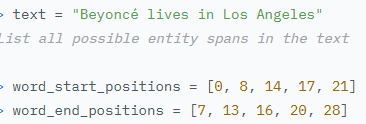

In [6]:
print(get_word_bounds("Beyoncé lives in Los Angeles"))

([0, 8, 14, 17, 21], [7, 13, 16, 20, 28])


Next we need to extract all of the possible entity spans of a certain length (128 as used in the LUKE example)

In [7]:
def extract_entity_spans(sentence: str):
  start_positions, end_positions = get_word_bounds(sentence)
  return [(start, end) for i, start in enumerate(start_positions) for end in end_positions[i:] if end-start<=128]

In [8]:
print(extract_entity_spans("Beyoncé lives in Los Angeles"))

[(0, 7), (0, 13), (0, 16), (0, 20), (0, 28), (8, 13), (8, 16), (8, 20), (8, 28), (14, 16), (14, 20), (14, 28), (17, 20), (17, 28), (21, 28)]


In [9]:
data = load_dataset("conll2003", split="test")
data_joined = data.map(lambda x: {"tokens": " ".join(x["tokens"])})

json_tokenized = []
for row in data_joined:
  json_tokenized.append({**tokenizer(row['tokens'], entity_spans=extract_entity_spans(row['tokens']), return_tensors='pt')})


In [ ]:

logits = []

for tok in json_tokenized:
  logits.append(model(**tok))